In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [ ]:
import os
import string
from collections import defaultdict
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
import numpy as np
import random
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB7, ResNet152
from tensorflow.keras.layers import GlobalAveragePooling2D
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, Dropout, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GRU, BatchNormalization, Concatenate, LayerNormalization
from tensorflow.keras.regularizers import l2

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
def load_captions(filename):
    captions = {}
    with open(filename, 'r') as file:
        for line in file:
            tokens = line.strip().split('\t')
            if len(tokens) == 2:
                image_id, caption = tokens
                image_id = image_id.split('#')[0]
                captions.setdefault(image_id, []).append(caption)
    return captions
captions = load_captions('Flickr8k.token.txt')
print('Total images with captions:', len(captions))

Total images with captions: 8092


In [ ]:
print("Sample captions:")
for img, caps in list(captions.items())[:3]:
    print(f"\nImage ID: {img}")
    for cap in caps:
        print(f"- {cap}")


Sample captions:

Image ID: 1000268201_693b08cb0e.jpg
- A child in a pink dress is climbing up a set of stairs in an entry way .
- A girl going into a wooden building .
- A little girl climbing into a wooden playhouse .
- A little girl climbing the stairs to her playhouse .
- A little girl in a pink dress going into a wooden cabin .

Image ID: 1001773457_577c3a7d70.jpg
- A black dog and a spotted dog are fighting
- A black dog and a tri-colored dog playing with each other on the road .
- A black dog and a white dog with brown spots are staring at each other in the street .
- Two dogs of different breeds looking at each other on the road .
- Two dogs on pavement moving toward each other .

Image ID: 1002674143_1b742ab4b8.jpg
- A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
- A little girl is sitting in front of a large painted rainbow .
- A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
- Th

In [ ]:
def preprocess_image(image_path, model_type='efficientnet'):
    try:
        if model_type == 'efficientnet':
            target_size = (600, 600)
            preprocess_fn = efficientnet_preprocess
        elif model_type == 'resnet':
            target_size = (448, 448)
            preprocess_fn = resnet_preprocess
        else:
            target_size = (224, 224)
            preprocess_fn = vgg16_preprocess

        image = load_img(image_path, target_size=target_size)
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)

        image = preprocess_fn(image)

        return image
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

In [ ]:
def clean_captions(captions_dict):
    table = str.maketrans('', '', string.punctuation)
    cleaned = {}
    for img, caps in captions_dict.items():
        cleaned_caps = []
        for cap in caps:
            cap = cap.lower()
            cap = cap.translate(table)
            cap = cap.split()
            cap = [word for word in cap if len(word) > 1 and word.isalpha()]
            cleaned_caps.append(' '.join(cap))
        cleaned[img] = cleaned_caps
    return cleaned

captions_cleaned = clean_captions(captions)

for img, caps in captions_cleaned.items():
    captions_cleaned[img] = ['startseq ' + cap + ' endseq' for cap in caps]

all_captions = []
for caps in captions_cleaned.values():
    all_captions.extend(caps)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size:", vocab_size)

max_length = max(len(c.split()) for c in all_captions)
print("Max caption length:", max_length)

Vocabulary size: 8766
Max caption length: 34


In [ ]:
def extract_features_batch(directory, batch_size=32, model_type='efficientnet'):

    if model_type == 'efficientnet':
        base_model = EfficientNetB7(weights='imagenet', include_top=False, pooling='avg')
    elif model_type == 'resnet':
        base_model = ResNet152(weights='imagenet', include_top=False, pooling='avg')
    else:
        base_model = VGG16(weights='imagenet')
        base_model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

    features = {}
    image_paths = [f for f in os.listdir(directory) if f.lower().endswith('.jpg')]

    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = []

        for img_name in batch_paths:
            img_path = os.path.join(directory, img_name)
            img = preprocess_image(img_path)
            if img is not None:
                batch_images.append(img)

        if batch_images:
            batch_images = np.vstack(batch_images)
            batch_features = base_model.predict(batch_images, verbose=0)

            for j, img_name in enumerate(batch_paths):
                if j < len(batch_features):
                    features[img_name] = batch_features[j].flatten()

    print(f"\nTotal extracted features ({model_type.upper()}):", len(features))
    return features

features = extract_features_batch("Flicker8k_Dataset", model_type='efficientnet')

I0000 00:00:1745980361.574079      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745980361.574787      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


  0%|          | 0/253 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1745980380.646373      81 service.cc:148] XLA service 0x7e65cc003600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745980380.647353      81 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745980380.647373      81 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745980382.805332      81 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1745980388.884718      81 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-04-30 02:33:09.190482: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[32,32,300,300]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,300,300]{


Total extracted features (EFFICIENTNET): 8091


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, descriptions, photos, tokenizer, max_length, vocab_size,
                 batch_size=32, shuffle=True, feature_dim=2560):
        self.descriptions = descriptions
        self.photos = photos
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.feature_dim = feature_dim

        self.image_ids = [img_id for img_id in descriptions.keys()
                         if img_id in photos and photos[img_id] is not None]
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        batch_ids = self.image_ids[index*self.batch_size:(index+1)*self.batch_size]
        X1, X2, y = self.__data_generation(batch_ids)

        if len(X1) == 0:
            X1 = np.zeros((0, self.feature_dim))
            X2 = np.zeros((0, self.max_length))
            y = np.zeros((0, self.vocab_size))

        return {'input_1': tf.convert_to_tensor(X1, dtype=tf.float32),
                'input_2': tf.convert_to_tensor(X2, dtype=tf.int32)}, \
               tf.convert_to_tensor(y, dtype=tf.float32)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_ids)

    def __data_generation(self, batch_ids):
        X1, X2, y = [], [], []

        for image_id in batch_ids:
            photo = self.photos.get(image_id)
            if photo is None:
                continue

            if len(photo) != self.feature_dim:
                continue

            desc_list = self.descriptions.get(image_id, [])
            for desc in desc_list:
                seq = self.tokenizer.texts_to_sequences([desc])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

        if len(X1) > 0:
            return np.array(X1), np.array(X2), np.array(y)
        return np.zeros((0, self.feature_dim)), np.zeros((0, self.max_length)), np.zeros((0, self.vocab_size))

    def get_sample_weights(self):
        """Optional: Compute sample weights to handle class imbalance"""
        word_counts = np.zeros(self.vocab_size)
        for desc_list in self.descriptions.values():
            for desc in desc_list:
                seq = self.tokenizer.texts_to_sequences([desc])[0]
                for word_idx in seq:
                    word_counts[word_idx] += 1

        weights = 1. / (word_counts + 1e-6)
        return weights / weights.mean()

In [ ]:
def build_model(vocab_size, max_length, feature_size=2560):
    input1 = Input(shape=(feature_size,), name='input_1')

    fe1 = Dense(1024, activation='relu', kernel_regularizer=l2(1e-4))(input1)
    fe1 = LayerNormalization()(fe1)
    fe1 = Dropout(0.4)(fe1)

    fe2 = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(fe1)
    fe2 = BatchNormalization()(fe2)
    image_features = Dropout(0.3)(fe2)

    input2 = Input(shape=(max_length,), name='input_2')

    se1 = Embedding(vocab_size, 512, mask_zero=True)(input2)
    se1 = Dropout(0.3)(se1)

    gru1 = GRU(512, return_sequences=False, implementation=0)(se1)
    gru1 = LayerNormalization()(gru1)
    gru1 = Dropout(0.3)(gru1)

    combined = Concatenate()([image_features, gru1])

    decoder1 = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(combined)
    decoder1 = BatchNormalization()(decoder1)
    decoder1 = Dropout(0.4)(decoder1)

    decoder2 = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(decoder1)
    decoder2 = LayerNormalization()(decoder2)

    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[input1, input2], outputs=outputs)

    optimizer = Adam(
        learning_rate=0.0005,
        clipnorm=1.0
    )

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

In [ ]:
image_ids = list(captions_cleaned.keys())
random.shuffle(image_ids)

split_index = int(0.8 * len(image_ids))
train_image_ids = image_ids[:split_index]
test_image_ids = image_ids[split_index:]

train_descriptions = {img: captions_cleaned[img] for img in train_image_ids}
test_descriptions = {img: captions_cleaned[img] for img in test_image_ids}

batch_size = 32

train_generator = DataGenerator(train_descriptions, features, tokenizer, max_length, vocab_size, batch_size)
test_generator = DataGenerator(test_descriptions, features, tokenizer, max_length, vocab_size, batch_size)

model = build_model(vocab_size, max_length)
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)      │ (None, 2560)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1024)           │      2,622,464 │ input_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_2 (InputLayer)      │ (None, 34)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 1024)           │          2,048 │ dense[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 34, 512)        │      4,488,192 │ input_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1024)           │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 34, 512)        │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 34)             │              0 │ input_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │        524,800 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ (None, 512)            │      1,575,936 │ dropout_2[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512)            │          2,048 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 512)            │          1,024 │ gru[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 512)            │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 512)            │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1024)           │              0 │ dropout_1[0][0],       │
│                           │                        │                │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │        524,800 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512)            │          2,048 │ dense_2[0][0]          │
│ (BatchNormalization) 

 Total params: 12,128,062 (46.26 MB)

 Trainable params: 12,126,014 (46.26 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [ ]:
checkpoint = ModelCheckpoint('best_model.keras',
                           monitor='val_loss',
                           save_best_only=True,
                           mode='min')

early_stopping = EarlyStopping(monitor='val_loss',
                             patience=3,
                             restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


203/203 ━━━━━━━━━━━━━━━━━━━━ 94s 403ms/step - accuracy: 0.1245 - loss: 7.2422 - val_accuracy: 0.2600 - val_loss: 4.4911
Epoch 2/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 84s 404ms/step - accuracy: 0.2690 - loss: 4.3449 - val_accuracy: 0.3011 - val_loss: 3.9846
Epoch 3/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 83s 397ms/step - accuracy: 0.3023 - loss: 3.8829 - val_accuracy: 0.3203 - val_loss: 3.7624
Epoch 4/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 81s 387ms/step - accuracy: 0.3265 - loss: 3.6058 - val_accuracy: 0.3323 - val_loss: 3.6422
Epoch 5/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 83s 396ms/step - accuracy: 0.3402 - loss: 3.4229 - val_accuracy: 0.3413 - val_loss: 3.5533
Epoch 6/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 80s 382ms/step - accuracy: 0.3530 - loss: 3.2799 - val_accuracy: 0.3452 - val_loss: 3.5193
Epoch 7/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 82s 394ms/step - accuracy: 0.3662 - loss: 3.1468 - val_accuracy: 0.3488 - val_loss: 3.4794
Epoch 8/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 82s 394ms/step - accuracy: 0.3736 - loss: 3.0473 - val

In [ ]:
def generate_caption(model, image_path, tokenizer, max_length, model_type='efficientnet'):
    photo = preprocess_image(image_path, model_type=model_type)
    if photo is None:
        print("Image preprocessing failed.")
        return None

    if model_type == 'efficientnet':
        feature_model = EfficientNetB7(weights='imagenet', include_top=False, pooling='avg')
    elif model_type == 'resnet':
        feature_model = ResNet152(weights='imagenet', include_top=False, pooling='avg')
    else:
        feature_model = VGG16(weights='imagenet')
        feature_model = Model(inputs=feature_model.inputs, outputs=feature_model.layers[-2].output)

    feature = feature_model.predict(photo, verbose=0)

    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        yhat = model.predict([feature, sequence], verbose=0)
        yhat_idx = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_idx, None)

        if word is None or word == 'endseq':
            break

        in_text += ' ' + word

    return in_text.replace('startseq', '').replace('endseq', '').strip()

Image: gp8_15e29595.jpg
Caption: group of people are standing in front of large building



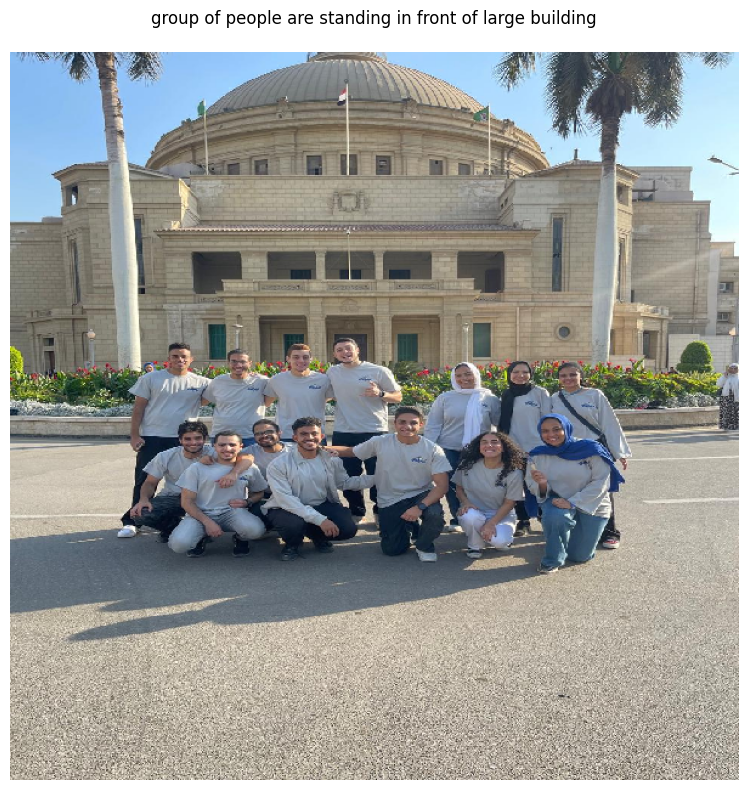

Image: WhatsApp Image 2025-04-30 at 04.02.12 (1).jpeg
Caption: baby is sitting on the floor



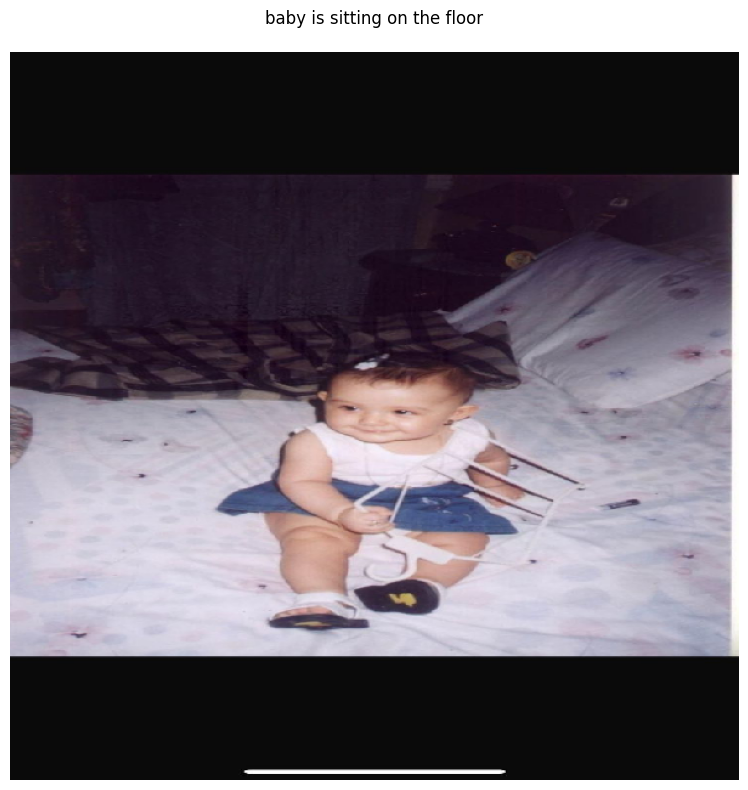

Image: WhatsApp Image 2025-04-30 at 05.04.29.jpeg
Caption: two women are walking down the street



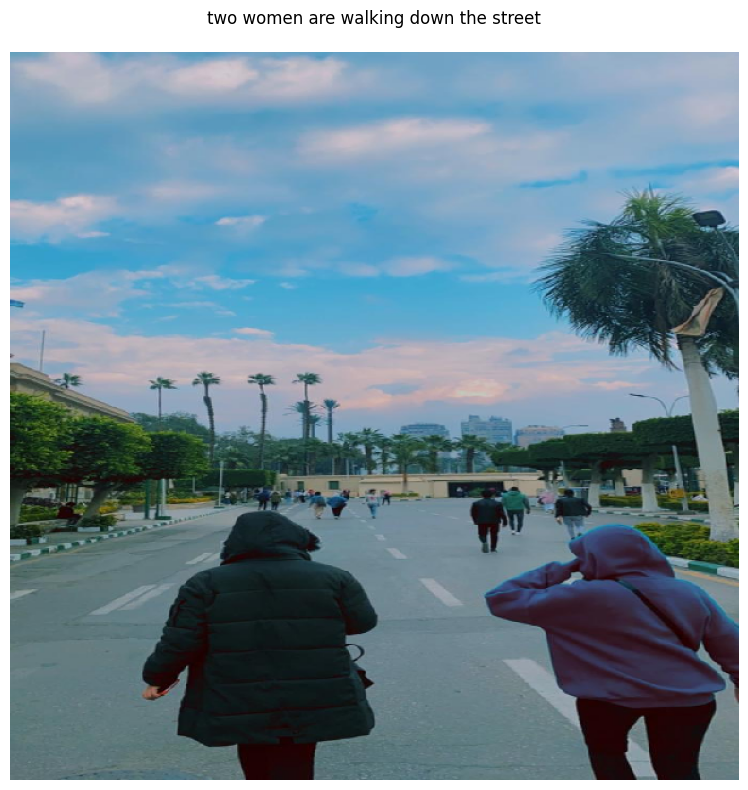

Image: WhatsApp Image 2025-04-30 at 04.57.33.jpeg
Caption: girl in white shirt is dancing



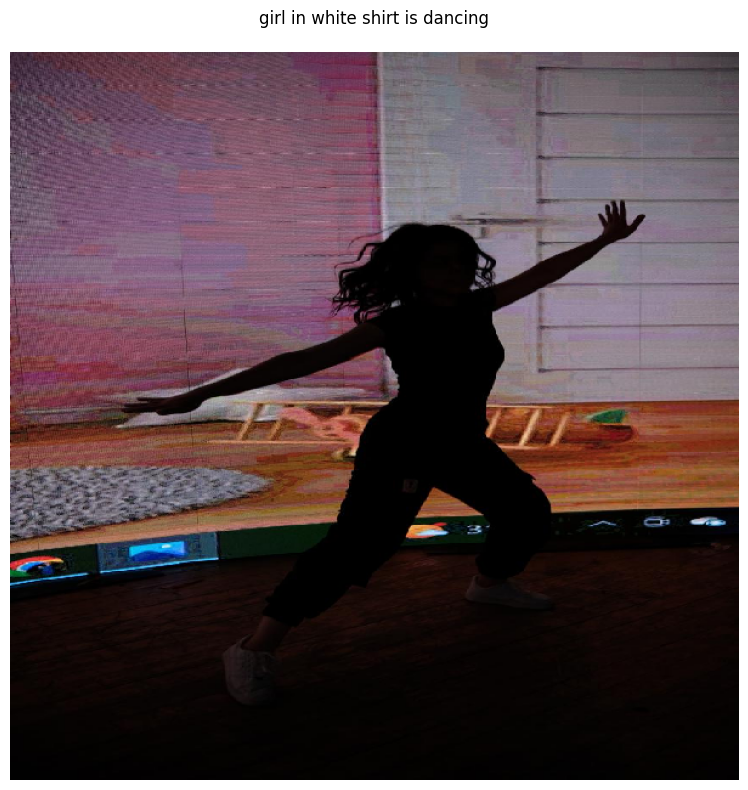

Image: babys.jpg
Caption: two young boys sit on the floor



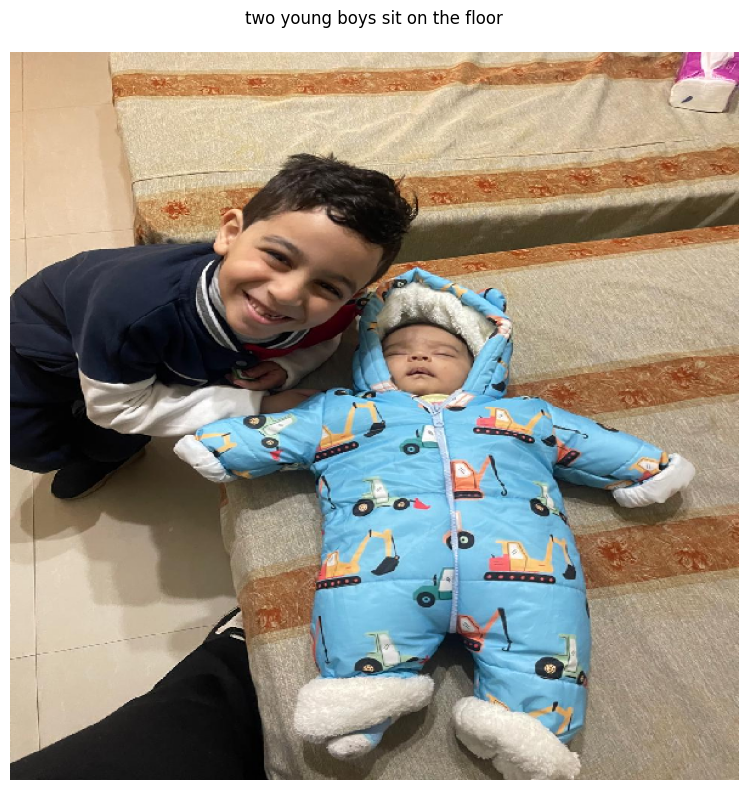

Image: WhatsApp Image 2025-04-29 at 23.01.31_b2b63591.jpg
Caption: two women in colorful costumes are sitting in front of an outdoor table



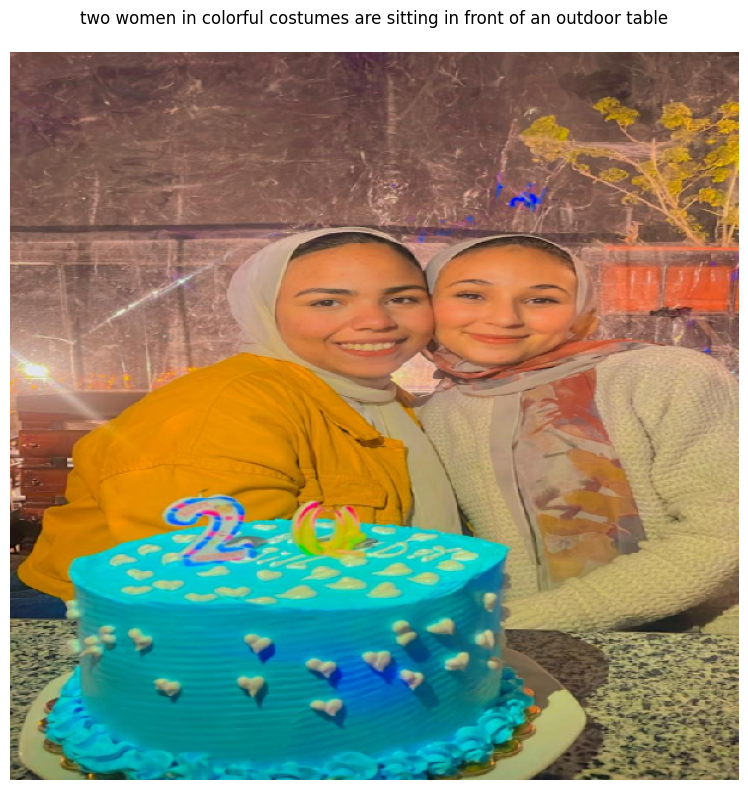

In [ ]:
def display_image_with_caption(image_path, caption, target_size=(600, 600)):
    img = load_img(image_path, target_size=target_size)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')

    wrapped_caption = '\n'.join([caption[i:i+80] for i in range(0, len(caption), 80)])
    plt.title(wrapped_caption, fontsize=12, pad=20)
    plt.tight_layout()
    plt.show()


image_paths = [
    '/kaggle/input/pic-dla/gp8_15e29595.jpg',
    '/kaggle/input/meralshma3a/WhatsApp Image 2025-04-30 at 04.02.12 (1).jpeg',
    '/kaggle/input/people/WhatsApp Image 2025-04-30 at 05.04.29.jpeg',
    '/kaggle/input/dancing/WhatsApp Image 2025-04-30 at 04.57.33.jpeg',
    '/kaggle/input/pic-dla/babys.jpg',
    '/kaggle/input/pic-dla/WhatsApp Image 2025-04-29 at 23.01.31_b2b63591.jpg'
]

trained_model = load_model('best_model.keras')

for image_path in image_paths:
    try:
        caption = generate_caption(
            trained_model,
            image_path,
            tokenizer,
            max_length,
            model_type='efficientnet'
        )
        print(f"Image: {os.path.basename(image_path)}")
        print(f"Caption: {caption}\n")
        display_image_with_caption(image_path, caption)
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")